Device: cuda
Total airport service samples: 310

Dataset distribution:
  flight_status.................   50 samples
  baggage_issue.................   50 samples
  terminal_directions...........   60 samples
  special_assistance............   50 samples
  ground_transport..............   50 samples
  security_customs..............   50 samples

Dataset splits:
  Train: 217 samples
  Val:   46 samples
  Test:  47 samples

Train distribution:
  flight_status.................   35
  baggage_issue.................   35
  terminal_directions...........   42
  special_assistance............   35
  ground_transport..............   35
  security_customs..............   35

Sample queries per intent:
  flight_status............ 'what gate for Singapore Airlines'
  baggage_issue............ 'lost bag report'
  terminal_directions...... 'where is information counter'
  special_assistance....... 'accessible bathroom'
  ground_transport......... 'bus to city center'
  security_customs......... 'ba

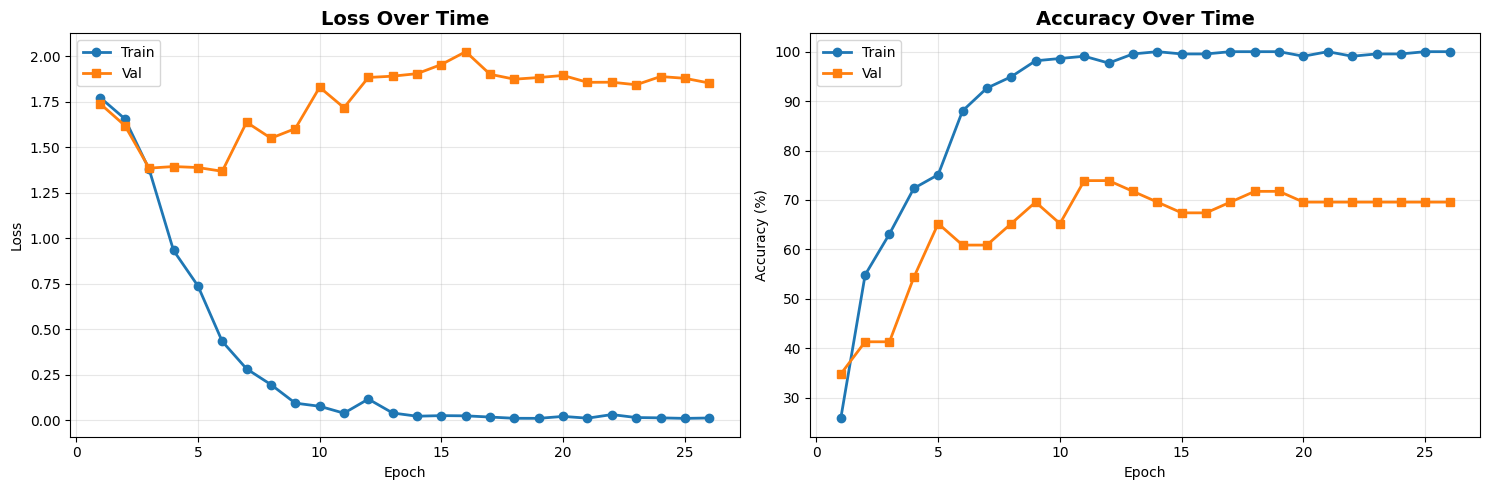


TEST SET RESULTS - AIRPORT SERVICE QUERIES

Test Accuracy: 59.57%

Classification Report:
                     precision    recall  f1-score   support

      flight_status       0.73      1.00      0.84         8
      baggage_issue       0.80      0.57      0.67         7
terminal_directions       0.75      0.67      0.71         9
 special_assistance       1.00      0.50      0.67         8
   ground_transport       0.31      0.62      0.42         8
   security_customs       0.33      0.14      0.20         7

           accuracy                           0.60        47
          macro avg       0.65      0.58      0.58        47
       weighted avg       0.66      0.60      0.59        47


Per-Class Performance:
  flight_status................. 100.00% (8/8)
  baggage_issue.................  57.14% (4/7)
  terminal_directions...........  66.67% (6/9)
  special_assistance............  50.00% (4/8)
  ground_transport..............  62.50% (5/8)
  security_customs..............  14.

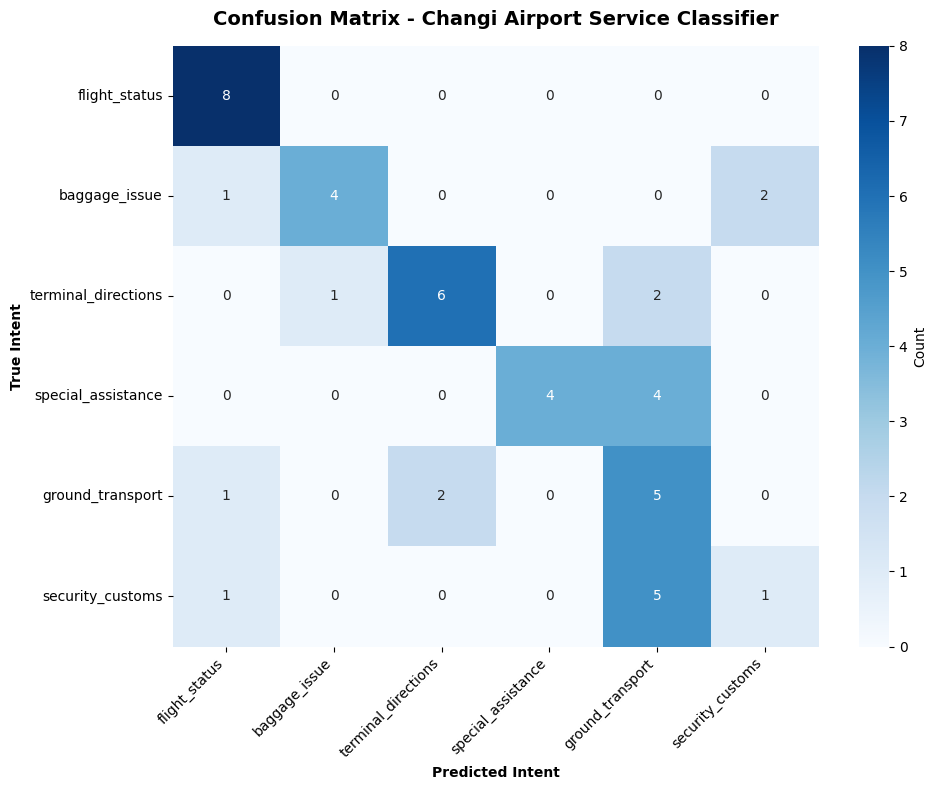


REAL AIRPORT QUERY PREDICTIONS

Query: 'What gate does my Singapore Airlines flight depart from?'
----------------------------------------------------------------------
  1. flight_status............... 100.0%  █████████████████████████████████
  2. special_assistance..........   0.0%  
  3. terminal_directions.........   0.0%  

Query: 'My luggage hasn't arrived at the baggage carousel'
----------------------------------------------------------------------
  1. baggage_issue............... 100.0%  █████████████████████████████████
  2. flight_status...............   0.0%  
  3. security_customs............   0.0%  

Query: 'How do I get to Jewel from Terminal 3?'
----------------------------------------------------------------------
  1. terminal_directions......... 100.0%  █████████████████████████████████
  2. flight_status...............   0.0%  
  3. security_customs............   0.0%  

Query: 'I need wheelchair assistance for my elderly father'
--------------------------------

In [1]:
"""
Changi Virtual Assist Triage - RNN Text Classification
Custom Airport Service Dataset
"""

# ============================================================================
# CELL 1: Setup and Imports
# ============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence

import numpy as np
from collections import Counter
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

torch.manual_seed(42)
np.random.seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# ============================================================================
# CELL 2: Create Airport Service Dataset
# ============================================================================

CHANGI_INTENTS = {
    0: "flight_status",
    1: "baggage_issue",
    2: "terminal_directions",
    3: "special_assistance",
    4: "ground_transport",
    5: "security_customs"
}

NUM_CLASSES = 6

# Comprehensive airport service queries dataset
AIRPORT_DATA = [
    # Flight Status (0) - 50 samples
    ("what time does my flight depart", 0),
    ("is my flight delayed", 0),
    ("check flight status", 0),
    ("when does boarding start", 0),
    ("what gate is my flight", 0),
    ("has my flight been cancelled", 0),
    ("flight arrival time", 0),
    ("gate change notification", 0),
    ("when will my flight arrive", 0),
    ("is the flight on time", 0),
    ("flight departure information", 0),
    ("what is the status of flight SQ123", 0),
    ("show me flight departures", 0),
    ("check if flight is boarding", 0),
    ("has boarding started", 0),
    ("what time is check in", 0),
    ("when does check in close", 0),
    ("flight arrival gate", 0),
    ("is there a gate change", 0),
    ("show arrivals board", 0),
    ("what terminal does my flight depart from", 0),
    ("flight schedule today", 0),
    ("is my connecting flight on time", 0),
    ("will I make my connection", 0),
    ("how long until boarding", 0),
    ("check departure time", 0),
    ("what gate for Singapore Airlines", 0),
    ("is Emirates flight delayed", 0),
    ("show me the departure board", 0),
    ("when is final boarding call", 0),
    ("has my flight left", 0),
    ("what time does the plane land", 0),
    ("flight information for BA12", 0),
    ("is Qantas flight on time", 0),
    ("check gate assignment", 0),
    ("when should I be at the gate", 0),
    ("flight status for Tokyo", 0),
    ("is there a delay", 0),
    ("show real time departures", 0),
    ("what time boarding", 0),
    ("gate number please", 0),
    ("has the gate opened", 0),
    ("check my flight", 0),
    ("is it time to board", 0),
    ("flight running late", 0),
    ("departure gate location", 0),
    ("where is my flight departing from", 0),
    ("check arrival status", 0),
    ("incoming flight from London", 0),
    ("what time will flight arrive", 0),

    # Baggage Issue (1) - 50 samples
    ("my luggage is missing", 1),
    ("bag not on carousel", 1),
    ("lost baggage claim", 1),
    ("damaged suitcase", 1),
    ("where is baggage claim", 1),
    ("my bag did not arrive", 1),
    ("report lost luggage", 1),
    ("baggage delayed", 1),
    ("suitcase damaged during flight", 1),
    ("file baggage claim", 1),
    ("lost bag report", 1),
    ("where is my luggage", 1),
    ("bag missing from carousel", 1),
    ("luggage not here", 1),
    ("damaged baggage claim", 1),
    ("my suitcase is broken", 1),
    ("bag went to wrong city", 1),
    ("luggage services office", 1),
    ("report damaged bag", 1),
    ("missing luggage counter", 1),
    ("bag didnt make connecting flight", 1),
    ("found wrong bag", 1),
    ("baggage claim area", 1),
    ("lost and found for luggage", 1),
    ("bag handle broken", 1),
    ("suitcase zipper damaged", 1),
    ("where to report lost bag", 1),
    ("baggage never arrived", 1),
    ("need to claim for damaged luggage", 1),
    ("my bag is lost", 1),
    ("luggage compensation", 1),
    ("bag arrived damaged", 1),
    ("suitcase has a hole", 1),
    ("baggage carousel not working", 1),
    ("which carousel for flight", 1),
    ("how to file baggage complaint", 1),
    ("luggage tracking", 1),
    ("bag tag says wrong destination", 1),
    ("delayed baggage claim form", 1),
    ("missing items from luggage", 1),
    ("someone took my bag", 1),
    ("wrong bag delivered", 1),
    ("bag contents damaged", 1),
    ("file insurance claim for bag", 1),
    ("get compensation for damaged suitcase", 1),
    ("bag delayed help", 1),
    ("luggage still not here", 1),
    ("track my missing bag", 1),
    ("baggage office location", 1),
    ("report baggage problem", 1),

    # Terminal Directions (2) - 60 samples
    ("where is terminal 2", 2),
    ("how to get to terminal 3", 2),
    ("directions to immigration", 2),
    ("where is the lounge", 2),
    ("how to reach Jewel", 2),
    ("location of duty free", 2),
    ("where is baggage claim", 2),
    ("find nearest restroom", 2),
    ("where are the shops", 2),
    ("how to get to gate C21", 2),
    ("directions to departure gates", 2),
    ("where is arrivals hall", 2),
    ("location of restaurants", 2),
    ("find charging station", 2),
    ("where is prayer room", 2),
    ("smoking area location", 2),
    ("how to walk between terminals", 2),
    ("where is transfer desk", 2),
    ("currency exchange location", 2),
    ("find ATM machine", 2),
    ("where is information counter", 2),
    ("location of pharmacy", 2),
    ("find medical clinic", 2),
    ("where is SilverKris lounge", 2),
    ("directions to butterfly garden", 2),
    ("where are the play areas", 2),
    ("find baby care room", 2),
    ("location of viewing mall", 2),
    ("where is hotel reservation desk", 2),
    ("find left luggage service", 2),
    ("directions to observation deck", 2),
    ("where is the cinema", 2),
    ("location of showers", 2),
    ("find sleeping pods", 2),
    ("where can I rest", 2),
    ("directions to transit hotel", 2),
    ("find free wifi zone", 2),
    ("where is business center", 2),
    ("location of meeting rooms", 2),
    ("where are the gates", 2),
    ("how to reach concourse B", 2),
    ("find nearest cafe", 2),
    ("where is Starbucks", 2),
    ("directions to food court", 2),
    ("location of convenience store", 2),
    ("where can I buy snacks", 2),
    ("find bookstore", 2),
    ("where is customs", 2),
    ("immigration hall location", 2),
    ("how to get to arrivals", 2),
    ("where is exit", 2),
    ("find taxi pickup point", 2),
    ("directions to train station", 2),
    ("where is the gym", 2),
    ("find swimming pool", 2),
    ("location of spa", 2),
    ("where can I shower", 2),
    ("directions to parking", 2),
    ("find car rental", 2),
    ("where is lost property", 2),

    # Special Assistance (3) - 50 samples
    ("I need wheelchair assistance", 3),
    ("request wheelchair", 3),
    ("help for disabled passenger", 3),
    ("special assistance services", 3),
    ("traveling with infant", 3),
    ("need baby stroller", 3),
    ("assistance for elderly", 3),
    ("help for visually impaired", 3),
    ("mobility assistance required", 3),
    ("where to get wheelchair", 3),
    ("escort service through airport", 3),
    ("need medical assistance", 3),
    ("traveling alone with toddler", 3),
    ("unaccompanied minor service", 3),
    ("help for hearing impaired", 3),
    ("nursing mother room", 3),
    ("baby changing facilities", 3),
    ("wheelchair accessible routes", 3),
    ("assistance for pregnant passenger", 3),
    ("priority boarding help", 3),
    ("meet and assist service", 3),
    ("porter service", 3),
    ("help carrying bags", 3),
    ("assistance navigating airport", 3),
    ("special needs support", 3),
    ("elderly passenger help", 3),
    ("request buggy service", 3),
    ("golf cart assistance", 3),
    ("help getting to gate", 3),
    ("disability services", 3),
    ("accessible bathroom", 3),
    ("service animal assistance", 3),
    ("guide dog facilities", 3),
    ("medical equipment transport", 3),
    ("oxygen assistance", 3),
    ("stretcher service", 3),
    ("ambulift service", 3),
    ("boarding assistance", 3),
    ("deplaning help", 3),
    ("connecting flight assistance", 3),
    ("wheelchair at arrival", 3),
    ("special meal request", 3),
    ("dietary requirements help", 3),
    ("assistance for injured passenger", 3),
    ("first aid services", 3),
    ("medical emergency", 3),
    ("need doctor", 3),
    ("nurse on duty", 3),
    ("traveling with disabilities", 3),
    ("reduced mobility help", 3),

    # Ground Transport (4) - 50 samples
    ("how to get downtown", 4),
    ("where is taxi stand", 4),
    ("bus to city center", 4),
    ("MRT station location", 4),
    ("train to downtown", 4),
    ("grab pickup point", 4),
    ("ride sharing location", 4),
    ("shuttle bus to hotel", 4),
    ("public transport options", 4),
    ("cheapest way to city", 4),
    ("taxi queue waiting time", 4),
    ("how much taxi to Marina Bay", 4),
    ("bus schedule", 4),
    ("airport shuttle service", 4),
    ("private car pickup", 4),
    ("limousine service", 4),
    ("where do taxis pick up", 4),
    ("train station directions", 4),
    ("bus stop location", 4),
    ("how to book shuttle", 4),
    ("taxi fare to Orchard Road", 4),
    ("metro to city", 4),
    ("public bus routes", 4),
    ("car rental counter", 4),
    ("where to rent a car", 4),
    ("hire vehicle service", 4),
    ("transportation to Sentosa", 4),
    ("how to reach hotel", 4),
    ("transport to cruise terminal", 4),
    ("bus to gardens by the bay", 4),
    ("train timetable", 4),
    ("uber pickup zone", 4),
    ("where taxis wait", 4),
    ("shared shuttle service", 4),
    ("private transfer booking", 4),
    ("coach to malaysia", 4),
    ("bus to johor bahru", 4),
    ("express train downtown", 4),
    ("shuttle bus schedule", 4),
    ("taxi rank location", 4),
    ("ride to convention center", 4),
    ("transport to exhibition hall", 4),
    ("how long taxi ride", 4),
    ("estimated fare", 4),
    ("prepaid taxi service", 4),
    ("metered taxi stand", 4),
    ("transport payment methods", 4),
    ("airport link train", 4),
    ("rapid transit options", 4),
    ("ground transportation desk", 4),

    # Security/Customs (5) - 50 samples
    ("what can I bring in carry on", 5),
    ("liquid restrictions", 5),
    ("prohibited items list", 5),
    ("customs declaration", 5),
    ("do I need to declare this", 5),
    ("immigration procedures", 5),
    ("visa requirements", 5),
    ("passport control location", 5),
    ("security screening process", 5),
    ("can I bring batteries", 5),
    ("duty free allowance", 5),
    ("what to declare at customs", 5),
    ("bringing alcohol limit", 5),
    ("tobacco allowance", 5),
    ("customs duty rates", 5),
    ("immigration form help", 5),
    ("arrival card filling", 5),
    ("departure card where to get", 5),
    ("visa on arrival", 5),
    ("transit visa needed", 5),
    ("security check procedures", 5),
    ("banned items", 5),
    ("restricted goods", 5),
    ("food import restrictions", 5),
    ("bringing medication", 5),
    ("prescription drugs declaration", 5),
    ("agricultural products customs", 5),
    ("plant quarantine", 5),
    ("animal products restrictions", 5),
    ("currency declaration limit", 5),
    ("how much cash to declare", 5),
    ("valuable items declaration", 5),
    ("electronics customs", 5),
    ("laptop battery rules", 5),
    ("power bank restrictions", 5),
    ("sharp objects in luggage", 5),
    ("sporting equipment rules", 5),
    ("musical instrument security", 5),
    ("liquids in checked baggage", 5),
    ("aerosols restrictions", 5),
    ("cosmetics allowance", 5),
    ("perfume quantity limit", 5),
    ("gifts customs declaration", 5),
    ("tax free shopping", 5),
    ("gst refund process", 5),
    ("customs inspection", 5),
    ("red channel green channel", 5),
    ("nothing to declare", 5),
    ("customs office location", 5),
    ("import permit requirements", 5),
]

print(f"Total airport service samples: {len(AIRPORT_DATA)}")
print(f"\nDataset distribution:")
for intent_id, intent_name in CHANGI_INTENTS.items():
    count = sum(1 for _, label in AIRPORT_DATA if label == intent_id)
    print(f"  {intent_name:.<30} {count:>4} samples")

# ============================================================================
# CELL 3: Prepare Data Splits
# ============================================================================

# Extract texts and labels
texts = [text for text, _ in AIRPORT_DATA]
labels = [label for _, label in AIRPORT_DATA]

# Split: 70% train, 15% val, 15% test
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.3, random_state=42, stratify=labels
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"\nDataset splits:")
print(f"  Train: {len(train_texts)} samples")
print(f"  Val:   {len(val_texts)} samples")
print(f"  Test:  {len(test_texts)} samples")

print("\nTrain distribution:")
train_dist = Counter(train_labels)
for i, intent in CHANGI_INTENTS.items():
    count = train_dist[i]
    print(f"  {intent:.<30} {count:>4}")

# Show sample queries
print("\nSample queries per intent:")
for intent_id in range(NUM_CLASSES):
    for text, label in zip(train_texts[:20], train_labels[:20]):
        if label == intent_id:
            print(f"  {CHANGI_INTENTS[intent_id]:.<25} '{text}'")
            break

# ============================================================================
# CELL 4: Text Preprocessing
# ============================================================================

class TextPreprocessor:
    def __init__(self):
        self.vocab = {'<PAD>': 0, '<UNK>': 1}
        self.word_to_idx = self.vocab.copy()

    def clean_text(self, text):
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s]', ' ', text)
        return re.sub(r'\s+', ' ', text).strip()

    def tokenize(self, text):
        return text.split()

    def build_vocab(self, texts, min_freq=1):
        word_freq = Counter()
        for text in texts:
            word_freq.update(self.tokenize(self.clean_text(text)))

        for word, freq in word_freq.items():
            if freq >= min_freq and word not in self.word_to_idx:
                self.word_to_idx[word] = len(self.word_to_idx)

        print(f"\nVocab size: {len(self.word_to_idx)} (min_freq={min_freq})")
        return self.word_to_idx

    def text_to_indices(self, text):
        tokens = self.tokenize(self.clean_text(text))
        return [self.word_to_idx.get(t, 1) for t in tokens]

preprocessor = TextPreprocessor()
preprocessor.build_vocab(train_texts, min_freq=1)

# Analyze sequence lengths
lengths = [len(preprocessor.text_to_indices(t)) for t in train_texts]
print(f"\nSequence length stats:")
print(f"  Mean: {np.mean(lengths):.1f}")
print(f"  Max: {np.max(lengths)}")
print(f"  Min: {np.min(lengths)}")

# ============================================================================
# CELL 5: PyTorch Dataset
# ============================================================================

class IntentDataset(Dataset):
    def __init__(self, texts, labels, preprocessor):
        self.texts = texts
        self.labels = labels
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        indices = self.preprocessor.text_to_indices(self.texts[idx])
        return {
            'indices': torch.LongTensor(indices),
            'label': torch.LongTensor([self.labels[idx]]),
            'length': len(indices)
        }

def collate_fn(batch):
    indices = pad_sequence([b['indices'] for b in batch], batch_first=True)
    labels = torch.cat([b['label'] for b in batch])
    lengths = torch.LongTensor([b['length'] for b in batch])
    return {'indices': indices, 'labels': labels, 'lengths': lengths}

BATCH_SIZE = 16

train_dataset = IntentDataset(train_texts, train_labels, preprocessor)
val_dataset = IntentDataset(val_texts, val_labels, preprocessor)
test_dataset = IntentDataset(test_texts, test_labels, preprocessor)

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, BATCH_SIZE, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, BATCH_SIZE, collate_fn=collate_fn)

print(f"\nBatches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

# ============================================================================
# CELL 6: RNN Model
# ============================================================================

class IntentRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes,
                 num_layers=2, dropout=0.4, bidirectional=True):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.emb_dropout = nn.Dropout(0.2)

        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers,
                           dropout=dropout if num_layers > 1 else 0,
                           bidirectional=bidirectional, batch_first=True)

        fc_input = hidden_dim * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(fc_input, num_classes)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        embedded = self.emb_dropout(embedded)

        packed = pack_padded_sequence(embedded, lengths.cpu(),
                                     batch_first=True, enforce_sorted=False)
        _, (hidden, _) = self.lstm(packed)

        if self.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]

        out = self.dropout(hidden)
        return self.fc(out)

VOCAB_SIZE = len(preprocessor.word_to_idx)
model = IntentRNN(
    vocab_size=VOCAB_SIZE,
    embed_dim=64,
    hidden_dim=128,
    num_classes=NUM_CLASSES,
    num_layers=2,
    dropout=0.4,
    bidirectional=True
).to(device)

print(f"\nModel: {model}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

# ============================================================================
# CELL 7: Training Functions
# ============================================================================

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch in loader:
        indices = batch['indices'].to(device)
        labels = batch['labels'].to(device)
        lengths = batch['lengths']

        optimizer.zero_grad()
        outputs = model(indices, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(loader), 100 * correct / total

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            indices = batch['indices'].to(device)
            labels = batch['labels'].to(device)
            lengths = batch['lengths']

            outputs = model(indices, lengths)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader), 100 * correct / total, all_preds, all_labels

# ============================================================================
# CELL 8: Train Model
# ============================================================================

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

NUM_EPOCHS = 100
PATIENCE = 15
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0
patience_counter = 0

print("\nTraining airport service classifier...\n")

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+1:3d}/{NUM_EPOCHS} | "
          f"Train: {train_loss:.4f}, {train_acc:5.1f}% | "
          f"Val: {val_loss:.4f}, {val_acc:5.1f}%", end="")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), 'changi_airport_model.pth')
        print(" ✓")
    else:
        patience_counter += 1
        print()
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

model.load_state_dict(torch.load('changi_airport_model.pth'))
print(f"\nTraining complete! Best val accuracy: {best_val_acc:.2f}%")

# ============================================================================
# CELL 9: Visualize Training
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

epochs = range(1, len(history['train_loss']) + 1)

ax1.plot(epochs, history['train_loss'], 'o-', label='Train', linewidth=2)
ax1.plot(epochs, history['val_loss'], 's-', label='Val', linewidth=2)
ax1.set_title('Loss Over Time', fontweight='bold', fontsize=14)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(epochs, history['train_acc'], 'o-', label='Train', linewidth=2)
ax2.plot(epochs, history['val_acc'], 's-', label='Val', linewidth=2)
ax2.set_title('Accuracy Over Time', fontweight='bold', fontsize=14)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ============================================================================
# CELL 10: Test Set Evaluation
# ============================================================================

_, test_acc, y_pred, y_true = evaluate(model, test_loader, criterion)

print(f"\n{'='*70}")
print("TEST SET RESULTS - AIRPORT SERVICE QUERIES")
print(f"{'='*70}")
print(f"\nTest Accuracy: {test_acc:.2f}%\n")

intent_names = [CHANGI_INTENTS[i] for i in range(NUM_CLASSES)]
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=intent_names, zero_division=0))

print("\nPer-Class Performance:")
cm = confusion_matrix(y_true, y_pred)
for i, intent in enumerate(intent_names):
    tp = cm[i, i]
    total = cm[i].sum()
    acc = 100 * tp / total if total > 0 else 0
    print(f"  {intent:.<30} {acc:>6.2f}% ({tp}/{total})")

# ============================================================================
# CELL 11: Confusion Matrix
# ============================================================================

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=intent_names, yticklabels=intent_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Changi Airport Service Classifier',
          fontweight='bold', fontsize=14, pad=15)
plt.ylabel('True Intent', fontweight='bold')
plt.xlabel('Predicted Intent', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ============================================================================
# CELL 12: Inference Function
# ============================================================================

def predict_intent(text, top_k=3):
    """Predict intent for airport service query"""
    model.eval()
    indices = preprocessor.text_to_indices(text)
    if not indices:
        return [{'intent': 'unknown', 'confidence': 0}]

    indices_t = torch.LongTensor(indices).unsqueeze(0).to(device)
    length_t = torch.LongTensor([len(indices)])

    with torch.no_grad():
        outputs = model(indices_t, length_t)
        probs = torch.softmax(outputs, 1)[0]

    top_probs, top_idx = torch.topk(probs, min(top_k, NUM_CLASSES))
    return [{'intent': CHANGI_INTENTS[i.item()], 'confidence': p.item() * 100}
            for p, i in zip(top_probs, top_idx)]

# ============================================================================
# CELL 13: Test Real Airport Queries
# ============================================================================

test_queries = [
    "What gate does my Singapore Airlines flight depart from?",
    "My luggage hasn't arrived at the baggage carousel",
    "How do I get to Jewel from Terminal 3?",
    "I need wheelchair assistance for my elderly father",
    "Where can I catch a taxi to downtown Singapore?",
    "What items are prohibited in carry-on baggage?",
    "Is flight SQ308 to London delayed?",
    "My suitcase was damaged during the flight",
    "Where is the immigration counter in Terminal 2?",
    "Can I get special assistance for traveling with an infant?",
    "How much does a taxi cost to Marina Bay Sands?",
    "Do I need to declare alcohol purchases?",
    "Where can I find a restroom near gate B12?",
    "What time does boarding start for my flight?",
    "I need to report a lost bag",
]

print(f"\n{'='*70}")
print("REAL AIRPORT QUERY PREDICTIONS")
print(f"{'='*70}\n")

for query in test_queries:
    print(f"Query: '{query}'")
    print("-" * 70)
    preds = predict_intent(query, top_k=3)
    for i, pred in enumerate(preds, 1):
        bar = "█" * int(pred['confidence'] / 3)
        print(f"  {i}. {pred['intent']:.<28} {pred['confidence']:>5.1f}%  {bar}")
    print()

# ============================================================================
# CELL 14: Test on Dataset Examples
# ============================================================================

print(f"{'='*70}")
print("PREDICTIONS ON TEST SET EXAMPLES")
print(f"{'='*70}\n")

# Show 12 random test examples
indices = np.random.choice(len(test_texts), min(12, len(test_texts)), replace=False)

correct_predictions = 0
total_predictions = 0

for idx in indices:
    text = test_texts[idx]
    true_label = test_labels[idx]
    true_intent = CHANGI_INTENTS[true_label]

    print(f"Query: '{text}'")
    print(f"True: {true_intent}")
    print("-" * 70)

    preds = predict_intent(text, top_k=3)

    for i, pred in enumerate(preds, 1):
        marker = "✓" if pred['intent'] == true_intent else " "
        bar = "█" * int(pred['confidence'] / 4)
        print(f"{marker} {i}. {pred['intent']:.<28} {pred['confidence']:>5.1f}%  {bar}")

        if i == 1 and pred['intent'] == true_intent:
            correct_predictions += 1

    total_predictions += 1
    print()

print(f"Accuracy on shown examples: {100 * correct_predictions / total_predictions:.1f}%")

# ============================================================================
# CELL 15: Interactive Demo (Optional)
# ============================================================================

def interactive_demo():
    """Interactive demo for testing the classifier"""
    print(f"\n{'='*70}")
    print("CHANGI AIRPORT VIRTUAL ASSIST - INTERACTIVE DEMO")
    print(f"{'='*70}")
    print("\nEnter airport service queries to classify (type 'quit' to exit)")
    print("\nExample queries:")
    print("  - Where is my gate?")
    print("  - My bag is missing")
    print("  - How to get downtown?")
    print("  - I need wheelchair help")
    print(f"\n{'='*70}\n")

    while True:
        query = input("Enter query: ").strip()

        if query.lower() in ['quit', 'exit', 'q']:
            print("\nThank you for using Changi Virtual Assist!")
            break

        if not query:
            continue

        print("\nPredicted Intents:")
        print("-" * 70)

        preds = predict_intent(query, top_k=3)

        for i, pred in enumerate(preds, 1):
            bar = "█" * int(pred['confidence'] / 2.5)
            print(f"{i}. {pred['intent']:.<30} {pred['confidence']:>6.2f}% {bar}")

        print()

# Uncomment to run interactive demo:
# interactive_demo()

# ============================================================================
# CELL 16: Error Analysis
# ============================================================================

print(f"\n{'='*70}")
print("ERROR ANALYSIS")
print(f"{'='*70}\n")

# Find misclassified examples
misclassified = []
for text, true_label, pred_label in zip(test_texts, y_true, y_pred):
    if true_label != pred_label:
        misclassified.append({
            'text': text,
            'true': CHANGI_INTENTS[true_label],
            'predicted': CHANGI_INTENTS[pred_label]
        })

print(f"Total misclassifications: {len(misclassified)} out of {len(test_texts)}")
print(f"Test accuracy: {100 * (len(test_texts) - len(misclassified)) / len(test_texts):.2f}%")

if misclassified:
    print(f"\nMisclassified Examples (showing up to 10):")
    print("-" * 70)
    for i, example in enumerate(misclassified[:10], 1):
        print(f"\n{i}. Query: '{example['text']}'")
        print(f"   True: {example['true']:.<25} | Predicted: {example['predicted']}")

# ============================================================================
# CELL 17: Model Summary and Insights
# ============================================================================

print(f"\n{'='*70}")
print("MODEL SUMMARY & PERFORMANCE INSIGHTS")
print(f"{'='*70}\n")

print("Model Architecture:")
print(f"  Type: Bidirectional LSTM")
print(f"  Embedding dim: 64")
print(f"  Hidden dim: 128")
print(f"  LSTM layers: 2")
print(f"  Dropout: 0.4")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

print(f"\nDataset Statistics:")
print(f"  Training samples: {len(train_texts)}")
print(f"  Validation samples: {len(val_texts)}")
print(f"  Test samples: {len(test_texts)}")
print(f"  Vocabulary size: {VOCAB_SIZE}")
print(f"  Number of intents: {NUM_CLASSES}")

print(f"\nPerformance Metrics:")
print(f"  Best validation accuracy: {best_val_acc:.2f}%")
print(f"  Test accuracy: {test_acc:.2f}%")
print(f"  Training epochs: {len(history['train_loss'])}")

# Calculate per-class F1 scores
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average=None, zero_division=0
)

print(f"\nPer-Intent Performance:")
print("-" * 70)
print(f"{'Intent':<30} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 70)
for i, intent in enumerate(intent_names):
    print(f"{intent:<30} {precision[i]:>10.2%}  {recall[i]:>10.2%}  {f1[i]:>10.2%}")

print(f"\n{'='*70}")

# ============================================================================
# CELL 18: Save Complete Model Checkpoint
# ============================================================================

checkpoint = {
    'model_state': model.state_dict(),
    'vocab': preprocessor.word_to_idx,
    'intents': CHANGI_INTENTS,
    'hyperparameters': {
        'vocab_size': VOCAB_SIZE,
        'embed_dim': 64,
        'hidden_dim': 128,
        'num_layers': 2,
        'dropout': 0.4,
        'bidirectional': True
    },
    'test_acc': test_acc,
    'best_val_acc': best_val_acc,
    'training_history': history
}

torch.save(checkpoint, 'changi_airport_rnn_complete.pth')
print(f"\n{'='*70}")
print("✓ Complete model checkpoint saved as 'changi_airport_rnn_complete.pth'")
print(f"  Test Accuracy: {test_acc:.2f}%")
print(f"  Best Val Accuracy: {best_val_acc:.2f}%")
print(f"\nTo load the model later, use:")
print("  checkpoint = torch.load('changi_airport_rnn_complete.pth')")
print("  model.load_state_dict(checkpoint['model_state'])")
print(f"{'='*70}\n")

# ============================================================================
# CELL 19: Usage Instructions
# ============================================================================

print(f"{'='*70}")
print("HOW TO USE THIS MODEL")
print(f"{'='*70}\n")

print("1. Make predictions on new queries:")
print("   predictions = predict_intent('where is my luggage?')")
print()

print("2. Get top-k predictions:")
print("   predictions = predict_intent('gate for my flight', top_k=3)")
print()

print("3. Access model components:")
print("   - model: The trained RNN model")
print("   - preprocessor: Text preprocessing utilities")
print("   - CHANGI_INTENTS: Intent label mapping")
print()

print("4. Run interactive demo:")
print("   interactive_demo()")
print()

print("5. Evaluate on custom data:")
print("   test_acc = evaluate(model, your_loader, criterion)")
print()

print(f"{'='*70}\n")

print("✅ All cells completed successfully!")
print("📊 Model ready for deployment at Changi Airport Virtual Assist!")
print(f"\n{'='*70}")